# Warehouse Storage Optimization

## 1. Storage Location Assignment

### Distance Matrix and Weights




In [6]:
import pandas as pd

# Required storage spaces needed data S_i
storage_spaces = {"A" : 3, "B" : 5, "C" : 2, "D" : 6}
total_spaces = sum(storage_spaces.values())

# Frequency of trips data f_ik
frequency = {"IO Point 1" : {"A" : 150, "B" : 60, "C" : 96, "D" : 175},
            "IO Point 2" : {"A" : 25, "B" : 200, "C" : 15, "D" : 135},
            "IO Point 3" : {"A" : 88, "B" : 150, "C" : 85, "D" : 90},
}
frequency_df = pd.DataFrame(frequency).loc[["A", "B", "C", "D"]]

# Cost data c_ik
cost = {"IO Point 1" : {"A" : 6, "B" : 7, "C" : 4, "D" : 15},
        "IO Point 2" : {"A" : 5, "B" : 3, "C" : 7, "D" : 8},
        "IO Point 3" : {"A" : 5, "B" : 6, "C" : 9, "D" : 12},
}
cost_df = pd.DataFrame(cost).loc[["A", "B", "C", "D"]]

# Define the IO points coordinates
io_points = {1: (2.5, 0.5), 2: (0.5, 2.5), 3: (2.5, 4.5)}

storage_locations = {}
idx = 1
for y in range(4, 0, -1):
    for x in range(1,5):
        storage_locations[idx] = (x, y)
        idx += 1

#print(storage_locations)

def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Calculate distance matrix d_kj
distance_matrix = pd.DataFrame(index=io_points.keys(), columns=storage_locations.keys())

for k, io_coord in io_points.items():
    for j, storage_coord in storage_locations.items():
        distance_matrix.loc[k, j] = manhattan_distance(io_coord, storage_coord)

print("Distance Matrix (d_kj): \n")
print(distance_matrix)

items = ["A", "B", "C", "D"]
weights_matrix = pd.DataFrame(index=items, columns=storage_locations.keys())

for i in items:
    for j in storage_locations.keys():
        total_weight = 0
        for k in io_points.keys():
            f_ik = frequency_df.loc[i, f"IO Point {k}"]
            c_ik = cost_df.loc[i, f"IO Point {k}"]
            d_kj = distance_matrix.loc[k, j]
            total_weight += f_ik * (c_ik + d_kj)
        weights_matrix.loc[i, j] = total_weight / total_spaces

print("Weight matrix w_ij (items × storage locations):")
print(weights_matrix)

Distance Matrix (d_kj): 

    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  \
1  5.0  4.0  4.0  5.0  4.0  3.0  3.0  4.0  3.0  2.0  2.0  3.0  2.0  1.0  1.0   
2  2.0  3.0  4.0  5.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0  2.0  3.0  4.0   
3  2.0  1.0  1.0  2.0  3.0  2.0  2.0  3.0  4.0  3.0  3.0  4.0  5.0  4.0  4.0   

    16  
1  2.0  
2  5.0  
3  5.0  
Weight matrix w_ij (items × storage locations):
         1        2         3         4        5         6         7   \
A  152.5625   139.25  140.8125    157.25  147.125  133.8125   135.375   
B     182.5  181.875   194.375     220.0  175.625     175.0     187.5   
C   120.875    110.5  111.4375  123.6875   119.25   108.875  109.8125   
D   381.875   373.75  382.1875  407.1875  368.125     360.0  368.4375   

         8         9         10       11        12        13        14  \
A  151.8125    143.25  129.9375    131.5  147.9375  140.9375   127.625   
B   213.125    181.25   180.625  193.125    218.75   19

### Mathematical Model (SLAP)

Optimal total travel cost: 107908
Slot -> Item assignment:
  1 : B
  2 : B
  3 : B
  4 : C
  5 : B
  6 : D
  7 : D
  8 : C
  9 : B
 10 : D
 11 : D
 12 : A
 13 : A
 14 : D
 15 : D
 16 : A
Assigned counts: {'B': 5, 'C': 2, 'D': 6, 'A': 3}


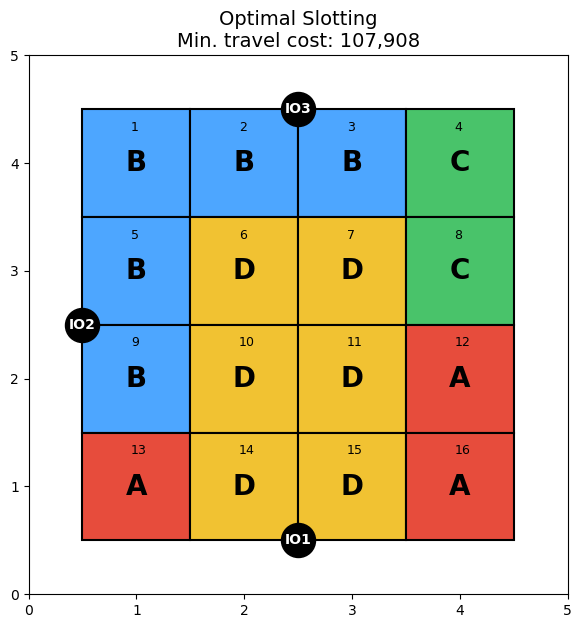

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Inputs
storage_spaces = {"A": 3, "B": 5, "C": 2, "D": 6}

frequency = {
    "IO Point 1": {"A": 150, "B": 60,  "C": 96, "D": 175},
    "IO Point 2": {"A": 25,  "B": 200, "C": 15, "D": 135},
    "IO Point 3": {"A": 88,  "B": 150, "C": 85, "D": 90},
}
frequency = pd.DataFrame(frequency)   # rows=A,B,C,D, columns=IO Point 1,2,3

cost = {
    "IO Point 1": {"A": 6,  "B": 7,  "C": 4,  "D": 15},
    "IO Point 2": {"A": 5,  "B": 3,  "C": 7,  "D": 8},
    "IO Point 3": {"A": 5,  "B": 6,  "C": 9,  "D": 12},
}
cost = pd.DataFrame(cost)


# Grid and centers
# slots numbered 1..16 left->right, top->bottom (1..4 top row, 13..16 bottom row)
slots = {}
n = 1
for y in range(4, 0, -1):         # y = 4,3,2,1 (top to bottom)
    for x in range(1, 5):         # x = 1..4 (left to right)
        slots[n] = (x, y)
        n += 1

centers = {s: (x - 0.5, y - 0.5) for s, (x, y) in slots.items()}

# I/O coordinates 
io_coords = {
    1: (2.5, 0.5),   # IO1
    2: (0.5, 2.5),   # IO2
    3: (2.5, 4.5),   # IO3
}

def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Build cost matrix: cost_{item,slot} = sum_p f_{i,p} * c_{i,p} * d_{p,slot}
items = ["A", "B", "C", "D"]
cost_matrix = pd.DataFrame(index=items, columns=sorted(centers.keys()), dtype=float)

for item in items:
    for s, center in centers.items():
        total = 0.0
        for p, io in io_coords.items():
            f = frequency.loc[item, f"IO Point {p}"]
            c = cost.loc[item, f"IO Point {p}"]
            d = manhattan(io, center)
            total += f * c * d
        cost_matrix.loc[item, s] = total

# Exact solver (dynamic programming over slots)
Q = storage_spaces.copy()
S = sorted(centers.keys())   # 1..16
num_slots = len(S)

dp = {(0, 0, 0, 0): 0.0}      # maps state -> min cost
parent = {}                   # parent[(idx, new_state)] = (old_state, item_assigned, slot)

for idx, slot in enumerate(S, start=1):
    next_dp = {}
    for state, cost_so_far in dp.items():
        a, b, c, d = state
        # try assign this slot to A
        if a < Q['A']:
            ns = (a + 1, b, c, d)
            new_cost = cost_so_far + cost_matrix.loc['A', slot]
            if ns not in next_dp or new_cost < next_dp[ns]:
                next_dp[ns] = new_cost
                parent[(idx, ns)] = (state, 'A', slot)
        # B
        if b < Q['B']:
            ns = (a, b + 1, c, d)
            new_cost = cost_so_far + cost_matrix.loc['B', slot]
            if ns not in next_dp or new_cost < next_dp[ns]:
                next_dp[ns] = new_cost
                parent[(idx, ns)] = (state, 'B', slot)
        # C
        if c < Q['C']:
            ns = (a, b, c + 1, d)
            new_cost = cost_so_far + cost_matrix.loc['C', slot]
            if ns not in next_dp or new_cost < next_dp[ns]:
                next_dp[ns] = new_cost
                parent[(idx, ns)] = (state, 'C', slot)
        # D
        if d < Q['D']:
            ns = (a, b, c, d + 1)
            new_cost = cost_so_far + cost_matrix.loc['D', slot]
            if ns not in next_dp or new_cost < next_dp[ns]:
                next_dp[ns] = new_cost
                parent[(idx, ns)] = (state, 'D', slot)
    dp = next_dp

final_state = (Q['A'], Q['B'], Q['C'], Q['D'])
if final_state not in dp:
    raise RuntimeError("No feasible assignment found.")
optimal_cost = dp[final_state]

# Reconstruct assignment
assignment = {s: None for s in S}
cur_state = final_state
for idx in range(num_slots, 0, -1):
    prev_state, item_assigned, slot_assigned = parent[(idx, cur_state)]
    assignment[slot_assigned] = item_assigned
    cur_state = prev_state


# Output results
print("Optimal total travel cost:", int(optimal_cost))
print("Slot -> Item assignment:")
for s in S:
    print(f" {s:2d} : {assignment[s]}")
print("Assigned counts:", dict(Counter(assignment.values())))


# Plot (axes 0..5 both directions, IOs at the requested coordinates)
colors = {"A": "#e74c3c", "B": "#4da6ff", "C": "#49c36a", "D":"#f1c232"}
fig, ax = plt.subplots(figsize=(7,7))

# draw cells
for s, (x, y) in slots.items():
    item = assignment[s]
    rect = plt.Rectangle((x - 0.5, y - 0.5), 1, 1, facecolor=colors[item], edgecolor="black", linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x, y , item, fontsize=20, fontweight="bold", ha="center", va="center")
    ax.text(x-0.05, y + 0.3, str(s), fontsize=9)

# draw IO points at exact coords (no shifts)
for p, (ix, iy) in io_coords.items():
    ax.scatter(ix, iy, s=600, c="black", zorder=6)
    ax.text(ix, iy, f"IO{p}", color="white", ha="center", va="center", fontsize=10, fontweight="bold", zorder=7)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_yticks([0,1,2,3,4,5])
ax.set_aspect("equal")
plt.title(f"Optimal Slotting\nMin. travel cost: {int(optimal_cost):,}", fontsize=14)
plt.show()




Example optimal assignment (illustrative only):

```
Min. travel cost: 42,420
 ╔═════════════ I/O ═════╦═══════╗
 ║   A       A       A   ║   B   ║
 ╠═══════════════╦═══════╣       ║
 ║   D       D   ║   C   ║   B   ║
I/O              ║       ║       ║
 ║   D       D   ║   C   ║   B   ║
 ║               ╠═══════╝       ║
 ║   D       D   ║   B       B   ║
 ╚═════════════ I/O ═════════════╝
```

### 2. Random vs. Dedicated Policies

The answer comprises:

- Total storage for dedicated policy.
- Total storage for random policy.
- Reasoning behind the totals.